In [71]:
from pathlib import Path
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import lit,to_timestamp, coalesce, col, date_format, when
from functools import reduce
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

In [4]:
from pathlib import Path

# Define la ruta base
base_path = Path("/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS")

# Lista 1: Archivos .csv que contienen "AQ_SEP" en su nombre
lista_aq_sep = [archivo for archivo in base_path.rglob("*.csv") if "AQ_SEP" in archivo.name]

# Lista 2: Archivos .csv que contienen "AirQualityUnit01" en su nombre
lista_airqualityunit01 = [archivo for archivo in base_path.rglob("*.csv") if "AirQualityUnit01" in archivo.name]

# Lista 3: Archivos .csv que contienen "AirQualityUnit02" en su nombre
lista_airqualityunit02 = [archivo for archivo in base_path.rglob("*.csv") if "AirQualityUnit02" in archivo.name]


In [5]:
# Imprimir las listas archivos AQ_SEP
print("Archivos con 'AQ_SEP':")
for archivo in lista_aq_sep:
    print(archivo)

Archivos con 'AQ_SEP':
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Abril 2024/6etmrenvironmentobserved - AQ_SEP-data-2024-04-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Junio 2024/6etmrenvironmentobserved - AQ_SEP, activa desde el 1ero de mayo-data-2024-06-14.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Agosto 2024/6etmrenvironmentobserved - AQ_SEP, activa desde el 1ero de mayo-data-2024-08-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Febrero 2024/6etmrenvironmentobserved - AQ_SEP-data-2024-02-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Diciembre 2023/6etmrenvironmentobserved - AQ_SEP-data-2023-12-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Marzo 2024/6etmrenvironmentobserved - AQ_SEP-data-2024-03-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Noviembre 2023/6etmrenvironmentobserved - AQ_SEP-data-2023-11-15.

In [6]:
# Imprimir las listas archivos AirQualityUnit01
print("\nArchivos con 'AirQualityUnit01':")
for archivo in lista_airqualityunit01:
    print(archivo)


Archivos con 'AirQualityUnit01':
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Abril 2024/7etmrairqualityobserved - AirQualityUnit01-data-2024-04-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Junio 2024/7etmrairqualityobserved - AirQualityUnit01-data-2024-06-14.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Julio 2024/7etmrairqualityobserved - AirQualityUnit01-data-2024-07-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Agosto 2024/7etmrairqualityobserved - AirQualityUnit01-data-2024-08-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Febrero 2024/7etmrairqualityobserved - AirQualityUnit01-data-2024-02-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Diciembre 2023/7etmrairqualityobserved - AirQualityUnit01-data-2023-12-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Marzo 2024/7etmrairqualityobserved - AirQualityUnit01-data-2

In [7]:
# Imprimir las listas archivos AirQualityUnit02
print("\nArchivos con 'AirQualityUnit02':")
for archivo in lista_airqualityunit02:
    print(archivo)


Archivos con 'AirQualityUnit02':
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Abril 2024/8etmrairqualityobserved - AirQualityUnit02-data-2024-04-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Junio 2024/8etmrairqualityobserved - AirQualityUnit02-data-2024-06-14.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Agosto 2024/8etmrairqualityobserved - AirQualityUnit02-data-2024-08-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Febrero 2024/8etmrairqualityobserved - AirQualityUnit02-data-2024-02-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Diciembre 2023/8etmrairqualityobserved - AirQualityUnit02-data-2023-12-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Marzo 2024/8etmrairqualityobserved - AirQualityUnit02-data-2024-03-15.csv
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/datos/DATOS/Noviembre 2023/8etmrairqualityobserved - AirQualityUnit02-da

In [8]:
def detect_separator_simple(file_path, sample_size=1024):
    """
    Detecta el separador de un archivo CSV leyendo una muestra del archivo.

    Args:
        file_path (str): Ruta del archivo CSV.
        sample_size (int, optional): Número de bytes a leer para el análisis. Por defecto es 1024.

    Returns:
        str: El caracter delimitador detectado o None si no se pudo detectar.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            sample = f.read(sample_size)
        dialect = csv.Sniffer().sniff(sample)
        return dialect.delimiter
    except Exception as e:
        print(f"Error al detectar el separador: {e}")
        return None


In [9]:
def load_csv_correctly(path):
    # Leer el archivo como texto
    raw_df = spark.read.text(path)
    # Obtener la primera línea
    first_line = raw_df.first()[0]
    separator = detect_separator_simple(path)
    
    if first_line and isinstance(first_line, str) and first_line.startswith("sep="):
        # Omitir la primera línea usando zipWithIndex para mantener el orden
        lines_rdd = raw_df.rdd.zipWithIndex() \
                        .filter(lambda row_index: row_index[1] > 0) \
                        .map(lambda row_index: row_index[0][0])
        
        # Leer el CSV a partir del RDD de líneas
        df = spark.read.option("header", "true") \
                       .option("inferSchema", "true") \
                       .option("escape", '"') \
                       .option("quote", '"') \
                       .option("sep", separator) \
                       .csv(lines_rdd)
    else:
        # Leer el CSV normalmente desde la ruta
        df = spark.read.option("header", "true") \
                       .option("inferSchema", "true") \
                       .option("escape", '"') \
                       .option("quote", '"') \
                       .option("sep", separator) \
                       .csv(path)
    
    return df


In [10]:
DF_LIST_AQ_SEP = [load_csv_correctly(str(path)) for path in lista_aq_sep]
DF_LIST_AQ_01 = [load_csv_correctly(str(path)) for path in lista_airqualityunit01]
DF_LIST_AQ_02 = [load_csv_correctly(str(path)) for path in lista_airqualityunit02]

In [11]:
DF_LIST_AQ_SEP[1].show()

+-------------------+---------+---------------+---------+----------+-----------+------------+---------------+------------------+
|               Time|co AQ_SEP|humidity AQ_SEP|o3 AQ_SEP|pm1 AQ_SEP|pm10 AQ_SEP|pm2_5 AQ_SEP|pressure AQ_SEP|temperature AQ_SEP|
+-------------------+---------+---------------+---------+----------+-----------+------------+---------------+------------------+
|2024-05-15 00:02:05|     10.1|           94.1|       -1|       0.2|        0.9|         0.8|          75332|              13.6|
|2024-05-15 00:17:05|      9.0|           95.3|       -1|       0.3|        0.4|         0.4|          75316|              13.6|
|2024-05-15 00:32:05|      9.7|           95.3|       -1|       0.3|        1.0|         0.9|          75297|              13.5|
|2024-05-15 00:47:06|      8.6|           95.0|       -1|       0.2|        0.2|         0.2|          75287|              13.5|
|2024-05-15 01:02:07|      7.5|           96.3|       -1|       0.1|        0.2|         0.2|    

In [12]:
DF_LIST_AQ_01[0].show()

+----------------+----------------+----+----+----+-----+------+----+-----------------+----+------------+
|            Time|       entity_id| co |co2 | o3 |pm10 |pm2_5 |pm5 |relativehumidity |so2 |temperature |
+----------------+----------------+----+----+----+-----+------+----+-----------------+----+------------+
|19/03/2024 22:08|AirQualityUnit01|-999|-999|-999| -999|  -999|-999|           -999.0|-999|      -998.0|
| 01/04/2024 9:33|AirQualityUnit01|-999|-999|-999| -999|  -999|-999|           -999.0|-999|      -999.0|
|08/04/2024 18:39|AirQualityUnit01|   2|1008|-999|   58|    44|  29|             60.3|-999|        20.3|
|08/04/2024 18:41|AirQualityUnit01|   3|1028|-999|   56|    46|  30|             60.3|-999|        20.3|
|08/04/2024 18:43|AirQualityUnit01|   4|1053|-999|   56|    46|  30|             60.3|-999|        20.3|
|08/04/2024 18:45|AirQualityUnit01|   5|1090|-999|   61|    46|  28|             60.4|-999|        20.3|
|08/04/2024 18:48|AirQualityUnit01|   6|1155|-999|   61

In [13]:
# Función para limpiar los nombres de columnas
def clean_column_names(df):
    new_columns = [col.strip().replace(" ", "_").lower() for col in df.columns]
    return df.toDF(*new_columns) 

In [14]:
DF_LIST_AQ_SEP = [clean_column_names(df) for df in DF_LIST_AQ_SEP]
DF_LIST_AQ_01 = [clean_column_names(df) for df in DF_LIST_AQ_01]
DF_LIST_AQ_02 = [clean_column_names(df) for df in DF_LIST_AQ_02]

In [15]:
for i, df in enumerate(DF_LIST_AQ_SEP):
    print(f"DataFrame DF_LIST_AQ_SEP {i} columns: {df.columns}")


DataFrame DF_LIST_AQ_SEP 0 columns: ['time', 'co_aq_sep', 'no2_aq_sep', 'o3_aq_sep', 'pm1_aq_sep', 'pm10_aq_sep', 'pm2_5_aq_sep', 'pressure_aq_sep', 'relativehumidity_aq_sep', 'temperature_aq_sep']
DataFrame DF_LIST_AQ_SEP 1 columns: ['time', 'co_aq_sep', 'humidity_aq_sep', 'o3_aq_sep', 'pm1_aq_sep', 'pm10_aq_sep', 'pm2_5_aq_sep', 'pressure_aq_sep', 'temperature_aq_sep']
DataFrame DF_LIST_AQ_SEP 2 columns: ['time', 'co_aq_sep', 'humidity_aq_sep', 'o3_aq_sep', 'pm1_aq_sep', 'pm10_aq_sep', 'pm2_5_aq_sep', 'pressure_aq_sep', 'temperature_aq_sep']
DataFrame DF_LIST_AQ_SEP 3 columns: ['time', 'co_aq_sep', 'no2_aq_sep', 'o3_aq_sep', 'pm1_aq_sep', 'pm10_aq_sep', 'pm2_5_aq_sep', 'pressure_aq_sep', 'relativehumidity_aq_sep', 'temperature_aq_sep']
DataFrame DF_LIST_AQ_SEP 4 columns: ['time', 'co_aq_sep', 'no2_aq_sep', 'o3_aq_sep', 'pm1_aq_sep', 'pm10_aq_sep', 'pm2_5_aq_sep', 'pressure_aq_sep', 'relativehumidity_aq_sep', 'temperature_aq_sep']
DataFrame DF_LIST_AQ_SEP 5 columns: ['time', 'co_aq_se

In [16]:
for i, df in enumerate(DF_LIST_AQ_01):
    print(f"DataFrame DF_LIST_AQ_01 {i} columns: {df.columns}")


DataFrame DF_LIST_AQ_01 0 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_01 1 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_01 2 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_01 3 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_01 4 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_01 5 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_01 6 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFr

In [17]:
for i, df in enumerate(DF_LIST_AQ_02):
    print(f"DataFrame DF_LIST_AQ_02 {i} columns: {df.columns}")


DataFrame DF_LIST_AQ_02 0 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_02 1 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_02 2 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_02 3 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_02 4 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_02 5 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFrame DF_LIST_AQ_02 6 columns: ['time', 'entity_id', 'co', 'co2', 'o3', 'pm10', 'pm2_5', 'pm5', 'relativehumidity', 'so2', 'temperature']
DataFr

In [18]:
def standardize_df(df):
    # Lista de columnas deseadas en el orden y con los nombres estándar
    desired_order = ["time", "pm2_5", "pm10", "co", "o3", "humidity", "temperature"]
    new_columns = []
    
    # Para cada columna deseada, buscar en el DataFrame original la primera columna que contenga la palabra clave
    for keyword in desired_order:
        # Buscar candidates: columnas cuyo nombre (en minúscula) contenga la palabra clave
        candidates = [col for col in df.columns if keyword in col.lower()]
        if candidates:
            # Si existen varias, se toma la primera (podrías ajustar esto si necesitas otro criterio)
            new_columns.append(F.col(candidates[0]).alias(keyword))
        else:
            # Si no existe la columna, se agrega una columna con valores nulos
            new_columns.append(F.lit(None).alias(keyword))
    
    # Seleccionar y devolver el nuevo DataFrame con las columnas en el orden deseado
    return df.select(*new_columns)

In [19]:
DF_LIST_AQ_SEP_S = [standardize_df(df) for df in DF_LIST_AQ_SEP]
TOTAL_LIST_AQ_SEP_S = 0
for i, df in enumerate(DF_LIST_AQ_SEP_S):
    print(f"DataFrame DF_LIST_AQ_SEP_S {i} columns: {df.columns} count: {df.count()}")
    TOTAL_LIST_AQ_SEP_S += df.count()
print(f"Total de filas en todos los DataFrames: {TOTAL_LIST_AQ_SEP_S}")
DF_LIST_AQ_SEP_S[0].show()

DataFrame DF_LIST_AQ_SEP_S 0 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 2927
DataFrame DF_LIST_AQ_SEP_S 1 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 1525
DataFrame DF_LIST_AQ_SEP_S 2 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 1591
DataFrame DF_LIST_AQ_SEP_S 3 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 2866
DataFrame DF_LIST_AQ_SEP_S 4 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 2765
DataFrame DF_LIST_AQ_SEP_S 5 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 2657
DataFrame DF_LIST_AQ_SEP_S 6 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 2959
DataFrame DF_LIST_AQ_SEP_S 7 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 2859
DataFrame DF_LIST_AQ_SEP_S 8 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'hum

In [20]:
DF_LIST_AQ_01_S = [standardize_df(df) for df in DF_LIST_AQ_01]
TOTAL_LIST_AQ_01_S = 0
for i, df in enumerate(DF_LIST_AQ_01_S):
    print(f"DataFrame DF_LIST_AQ_01_S {i} columns: {df.columns} count: {df.count()}")
    TOTAL_LIST_AQ_01_S += df.count()
print(f"Total de filas en todos los DataFrames: {TOTAL_LIST_AQ_01_S}")
DF_LIST_AQ_01_S[0].show()

DataFrame DF_LIST_AQ_01_S 0 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 2841
DataFrame DF_LIST_AQ_01_S 1 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 12962
DataFrame DF_LIST_AQ_01_S 2 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 14216
DataFrame DF_LIST_AQ_01_S 3 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 14879
DataFrame DF_LIST_AQ_01_S 4 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 14376
DataFrame DF_LIST_AQ_01_S 5 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 14168
DataFrame DF_LIST_AQ_01_S 6 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 13346
DataFrame DF_LIST_AQ_01_S 7 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 15215
DataFrame DF_LIST_AQ_01_S 8 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humid

In [21]:
DF_LIST_AQ_02_S = [standardize_df(df) for df in DF_LIST_AQ_02]
TOTAL_LIST_AQ_02_S = 0
for i, df in enumerate(DF_LIST_AQ_02_S):
    print(f"DataFrame DF_LIST_AQ_02_S {i} columns: {df.columns} count: {df.count()}")
    TOTAL_LIST_AQ_02_S += df.count()
print(f"Total de filas en todos los DataFrames: {TOTAL_LIST_AQ_02_S}")
DF_LIST_AQ_02_S[0].show()

DataFrame DF_LIST_AQ_02_S 0 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 2803
DataFrame DF_LIST_AQ_02_S 1 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 6471
DataFrame DF_LIST_AQ_02_S 2 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 3564
DataFrame DF_LIST_AQ_02_S 3 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 14385
DataFrame DF_LIST_AQ_02_S 4 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 13991
DataFrame DF_LIST_AQ_02_S 5 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 13471
DataFrame DF_LIST_AQ_02_S 6 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 14786
DataFrame DF_LIST_AQ_02_S 7 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidity', 'temperature'] count: 14245
DataFrame DF_LIST_AQ_02_S 8 columns: ['time', 'pm2_5', 'pm10', 'co', 'o3', 'humidit

In [22]:
# Combinar todos los DataFrames en uno solo - DF_LIST_AQ_SEP_S
DF_AQ_SEP = reduce(lambda df1, df2: df1.unionByName(df2), DF_LIST_AQ_SEP_S)
print(f"Total de filas en todos los DF_AQ_SEP: {DF_AQ_SEP.count()}")
DF_AQ_SEP.show()

Total de filas en todos los DF_AQ_SEP: 32172
+-------------------+-----+----+----+---+--------+-----------+
|               time|pm2_5|pm10|  co| o3|humidity|temperature|
+-------------------+-----+----+----+---+--------+-----------+
|2024-03-15 00:11:34|  0.5| 0.5|25.3|0.1|  -999.0|       11.5|
|2024-03-15 00:26:34|  0.7| 0.7|23.0|0.1|  -999.0|       11.6|
|2024-03-15 00:41:34|  0.7| 0.7|22.2|0.1|  -999.0|       11.2|
|2024-03-15 00:56:34|  0.6| 0.6|20.4|0.1|  -999.0|       11.1|
|2024-03-15 01:11:34|  0.6| 0.6|19.6|0.1|  -999.0|       10.6|
|2024-03-15 01:26:34|  0.5| 0.5|19.2|0.1|  -999.0|       10.6|
|2024-03-15 01:41:34|  0.7| 0.7|19.5|0.1|  -999.0|       10.4|
|2024-03-15 01:56:34|  0.6| 0.6|21.2|0.1|  -999.0|       10.5|
|2024-03-15 02:11:34|  0.5| 0.5|20.3|0.1|  -999.0|       10.1|
|2024-03-15 02:26:34|  0.6| 0.6|19.2|0.1|  -999.0|        9.9|
|2024-03-15 02:41:34|  0.5| 0.5|19.7|0.1|  -999.0|        9.7|
|2024-03-15 02:56:34|  0.4| 0.4|17.7|0.1|  -999.0|        9.1|
|2024-03-1

In [23]:
# Combinar todos los DataFrames en uno solo - DF_LIST_AQ_01_S
DF_AQ_1 = reduce(lambda df1, df2: df1.unionByName(df2), DF_LIST_AQ_01_S)
print(f"Total de filas en todos los DF_AQ_1: {DF_AQ_1.count()}")
DF_AQ_1.show()

Total de filas en todos los DF_AQ_1: 181913
+----------------+-----+----+----+----+--------+-----------+
|            time|pm2_5|pm10|  co|  o3|humidity|temperature|
+----------------+-----+----+----+----+--------+-----------+
|19/03/2024 22:08| -999|-999|-999|-999|  -999.0|     -998.0|
| 01/04/2024 9:33| -999|-999|-999|-999|  -999.0|     -999.0|
|08/04/2024 18:39|   44|  58|   2|-999|    60.3|       20.3|
|08/04/2024 18:41|   46|  56|   3|-999|    60.3|       20.3|
|08/04/2024 18:43|   46|  56|   4|-999|    60.3|       20.3|
|08/04/2024 18:45|   46|  61|   5|-999|    60.4|       20.3|
|08/04/2024 18:48|   45|  61|   6|-999|    60.5|       20.3|
|08/04/2024 18:50|   45|  61|   7|-999|    60.6|       20.3|
|08/04/2024 18:52|   46|  61|   8|-999|    60.7|       20.4|
|08/04/2024 18:54|   44|  53|   9|-999|    60.7|       20.4|
|08/04/2024 18:56|   44|  53|  10|-999|    60.7|       20.4|
|08/04/2024 19:00|   43|  52|  12|-999|     0.0|        0.0|
|08/04/2024 19:02|   40|  56|  13|-999|  

In [24]:
# Combinar todos los DataFrames en uno solo - DF_LIST_AQ_02_S
DF_AQ_2 = reduce(lambda df1, df2: df1.unionByName(df2), DF_LIST_AQ_02_S)
print(f"Total de filas en todos los DF_AQ_2: {DF_AQ_2.count()}")
DF_AQ_2.show()

Total de filas en todos los DF_AQ_2: 148552
+----------------+-----+----+----+----+--------+-----------+
|            time|pm2_5|pm10|  co|  o3|humidity|temperature|
+----------------+-----+----+----+----+--------+-----------+
|19/03/2024 22:09| -999|-999|-999|-999|  -999.0|     -998.0|
| 01/04/2024 9:33| -999|-999|-999|-999|  -999.0|     -999.0|
|08/04/2024 20:18|   39|  45|   1|-999|    78.0|       19.0|
|08/04/2024 20:20|   42|  54|   2|-999|    78.1|       19.3|
|08/04/2024 20:46|   40|  47|   1|-999|    72.0|       20.3|
|08/04/2024 20:48|   45|  59|   2|-999|    71.1|       20.4|
|08/04/2024 20:53|   44|  56|   4|-999|    69.5|       20.5|
|08/04/2024 20:55|   41|  51|   5|-999|    69.1|       20.5|
|08/04/2024 20:57|   41|  52|   6|-999|    68.7|       20.6|
|08/04/2024 20:59|   40|  52|   7|-999|    68.4|       20.6|
|08/04/2024 21:05|   38|  48|  10|-999|    67.7|       20.8|
|08/04/2024 21:07|   38|  51|  11|-999|    67.5|       20.8|
|08/04/2024 21:11|   39|  50|  13|-999|  

In [25]:
# Crear una condición que sea True cuando todas las columnas sean null

CONDITION = reduce(lambda acc, col: acc & F.col(col).isNull(), DF_AQ_2.columns, F.lit(True))

# Filtrar y contar las filas que cumplen la condición
DF_AQ_SEP_ALL_NULL = DF_AQ_SEP.filter(CONDITION).count()
DF_AQ_1_ALL_NULL = DF_AQ_1.filter(CONDITION).count()
DF_AQ_2_ALL_NULL = DF_AQ_2.filter(CONDITION).count()


print(" DF_AQ_SEP -> Cantidad de filas completamente null:", DF_AQ_SEP_ALL_NULL)
print(" DF_AQ_1 -> Cantidad de filas completamente null:", DF_AQ_1_ALL_NULL)
print(" DF_AQ_2 -> Cantidad de filas completamente null:", DF_AQ_2_ALL_NULL)

 DF_AQ_SEP -> Cantidad de filas completamente null: 0
 DF_AQ_1 -> Cantidad de filas completamente null: 0
 DF_AQ_2 -> Cantidad de filas completamente null: 0


In [26]:
def standardize_time_column(df):
    """
    Procesa la columna 'time' de un DataFrame y crea una nueva columna 'time_format'
    con el formato 'yyyy-MM-dd HH:mm:ss'.
    
    Considera varios formatos de fecha/hora:
      - dd/MM/yyyy H:mm       (Ej: 19/03/2024 22:09 o 01/04/2024 9:33)
      - yyyy-MM-dd H:mm:ss     (Ej: 2024-03-15 00:11:34)
      - yyyy-MM-dd H:mm        (Ej: 2024-03-15 11:34)
    """
    # Intenta convertir la columna "time" usando los diferentes formatos
    df = df.withColumn(
        "time_ts",
        coalesce(
            to_timestamp(col("time"), "dd/MM/yyyy H:mm"),
            to_timestamp(col("time"), "yyyy-MM-dd H:mm:ss"),
            to_timestamp(col("time"), "yyyy-MM-dd H:mm")
        )
    )
    
    # Formatea el timestamp al formato deseado y crea la nueva columna "time_format"
    df = df.withColumn("time_format", date_format(col("time_ts"), "yyyy-MM-dd HH:mm:ss"))
    
    # Elimina la columna intermedia si ya no es necesaria
    df = df.drop("time_ts")
    
    return df


In [27]:
#se crea una funcion que estandariza las fechas y agrega una nueva columna
DF_AQ_SEP = standardize_time_column(DF_AQ_SEP)
DF_AQ_1   = standardize_time_column(DF_AQ_1)
DF_AQ_2   = standardize_time_column(DF_AQ_2)


In [28]:
DF_AQ_SEP.show()

+-------------------+-----+----+----+---+--------+-----------+-------------------+
|               time|pm2_5|pm10|  co| o3|humidity|temperature|        time_format|
+-------------------+-----+----+----+---+--------+-----------+-------------------+
|2024-03-15 00:11:34|  0.5| 0.5|25.3|0.1|  -999.0|       11.5|2024-03-15 00:11:34|
|2024-03-15 00:26:34|  0.7| 0.7|23.0|0.1|  -999.0|       11.6|2024-03-15 00:26:34|
|2024-03-15 00:41:34|  0.7| 0.7|22.2|0.1|  -999.0|       11.2|2024-03-15 00:41:34|
|2024-03-15 00:56:34|  0.6| 0.6|20.4|0.1|  -999.0|       11.1|2024-03-15 00:56:34|
|2024-03-15 01:11:34|  0.6| 0.6|19.6|0.1|  -999.0|       10.6|2024-03-15 01:11:34|
|2024-03-15 01:26:34|  0.5| 0.5|19.2|0.1|  -999.0|       10.6|2024-03-15 01:26:34|
|2024-03-15 01:41:34|  0.7| 0.7|19.5|0.1|  -999.0|       10.4|2024-03-15 01:41:34|
|2024-03-15 01:56:34|  0.6| 0.6|21.2|0.1|  -999.0|       10.5|2024-03-15 01:56:34|
|2024-03-15 02:11:34|  0.5| 0.5|20.3|0.1|  -999.0|       10.1|2024-03-15 02:11:34|
|202

In [29]:
DF_AQ_1.show()

+----------------+-----+----+----+----+--------+-----------+-------------------+
|            time|pm2_5|pm10|  co|  o3|humidity|temperature|        time_format|
+----------------+-----+----+----+----+--------+-----------+-------------------+
|19/03/2024 22:08| -999|-999|-999|-999|  -999.0|     -998.0|2024-03-19 22:08:00|
| 01/04/2024 9:33| -999|-999|-999|-999|  -999.0|     -999.0|2024-04-01 09:33:00|
|08/04/2024 18:39|   44|  58|   2|-999|    60.3|       20.3|2024-04-08 18:39:00|
|08/04/2024 18:41|   46|  56|   3|-999|    60.3|       20.3|2024-04-08 18:41:00|
|08/04/2024 18:43|   46|  56|   4|-999|    60.3|       20.3|2024-04-08 18:43:00|
|08/04/2024 18:45|   46|  61|   5|-999|    60.4|       20.3|2024-04-08 18:45:00|
|08/04/2024 18:48|   45|  61|   6|-999|    60.5|       20.3|2024-04-08 18:48:00|
|08/04/2024 18:50|   45|  61|   7|-999|    60.6|       20.3|2024-04-08 18:50:00|
|08/04/2024 18:52|   46|  61|   8|-999|    60.7|       20.4|2024-04-08 18:52:00|
|08/04/2024 18:54|   44|  53

In [30]:
DF_AQ_2.show()

+----------------+-----+----+----+----+--------+-----------+-------------------+
|            time|pm2_5|pm10|  co|  o3|humidity|temperature|        time_format|
+----------------+-----+----+----+----+--------+-----------+-------------------+
|19/03/2024 22:09| -999|-999|-999|-999|  -999.0|     -998.0|2024-03-19 22:09:00|
| 01/04/2024 9:33| -999|-999|-999|-999|  -999.0|     -999.0|2024-04-01 09:33:00|
|08/04/2024 20:18|   39|  45|   1|-999|    78.0|       19.0|2024-04-08 20:18:00|
|08/04/2024 20:20|   42|  54|   2|-999|    78.1|       19.3|2024-04-08 20:20:00|
|08/04/2024 20:46|   40|  47|   1|-999|    72.0|       20.3|2024-04-08 20:46:00|
|08/04/2024 20:48|   45|  59|   2|-999|    71.1|       20.4|2024-04-08 20:48:00|
|08/04/2024 20:53|   44|  56|   4|-999|    69.5|       20.5|2024-04-08 20:53:00|
|08/04/2024 20:55|   41|  51|   5|-999|    69.1|       20.5|2024-04-08 20:55:00|
|08/04/2024 20:57|   41|  52|   6|-999|    68.7|       20.6|2024-04-08 20:57:00|
|08/04/2024 20:59|   40|  52

In [31]:
# Filtrar las filas donde time_format es null
df_null_time = DF_AQ_SEP.filter(col("time_format").isNull())
# Mostrar las filas filtradas
df_null_time.show()
# Opcional: contar el número de filas con time_format null
null_count = DF_AQ_SEP.filter(col("time_format").isNull()).count()
print("DF_AQ_SEP - Número de filas con time_format null:", null_count)

+----+-----+----+---+---+--------+-----------+-----------+
|time|pm2_5|pm10| co| o3|humidity|temperature|time_format|
+----+-----+----+---+---+--------+-----------+-----------+
+----+-----+----+---+---+--------+-----------+-----------+

DF_AQ_SEP - Número de filas con time_format null: 0


In [32]:
# Filtrar las filas donde time_format es null
df_null_time = DF_AQ_1.filter(col("time_format").isNull())
# Mostrar las filas filtradas
df_null_time.show()
# Opcional: contar el número de filas con time_format null
null_count = DF_AQ_1.filter(col("time_format").isNull()).count()
print("DF_AQ_1 - Número de filas con time_format null:", null_count)

+----+-----+----+---+---+--------+-----------+-----------+
|time|pm2_5|pm10| co| o3|humidity|temperature|time_format|
+----+-----+----+---+---+--------+-----------+-----------+
+----+-----+----+---+---+--------+-----------+-----------+



DF_AQ_1 - Número de filas con time_format null: 0


In [33]:
# Filtrar las filas donde time_format es null
df_null_time = DF_AQ_2.filter(col("time_format").isNull())
# Mostrar las filas filtradas
df_null_time.show()
# Opcional: contar el número de filas con time_format null
null_count = DF_AQ_2.filter(col("time_format").isNull()).count()
print("DF_AQ_2 - Número de filas con time_format null:", null_count)

+----+-----+----+---+---+--------+-----------+-----------+
|time|pm2_5|pm10| co| o3|humidity|temperature|time_format|
+----+-----+----+---+---+--------+-----------+-----------+
+----+-----+----+---+---+--------+-----------+-----------+



DF_AQ_2 - Número de filas con time_format null: 0


In [34]:
#despues de verificar que la columna time_format no tiene valores nulos se procede a eliminar la columna time
DF_AQ_SEP = DF_AQ_SEP.drop("time")
DF_AQ_1 = DF_AQ_1.drop("time")
DF_AQ_2 = DF_AQ_2.drop("time")

In [35]:
# Exportar DF_AQ_SEP a CSV en la ruta especificada
DF_AQ_SEP.write.mode("overwrite").option("header", "true").csv("/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/export/DF_AQ_SEP.csv")

# Exportar DF_AQ_1 a CSV
DF_AQ_1.write.mode("overwrite").option("header", "true").csv("/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/export/DF_AQ_1.csv")

# Exportar DF_AQ_2 a CSV
DF_AQ_2.write.mode("overwrite").option("header", "true").csv("/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/export/DF_AQ_2.csv")


In [36]:
DF_AQ_SEP = DF_AQ_SEP.withColumn("pm2_5",
    when(col("pm2_5") <= -990, None).otherwise(col("pm2_5"))
)
DF_AQ_SEP = DF_AQ_SEP.withColumn("pm10",
    when(col("pm10") <= -990, None).otherwise(col("pm10"))
)
DF_AQ_SEP = DF_AQ_SEP.withColumn("co",
    when(col("co") <= -990, None).otherwise(col("co"))
)
DF_AQ_SEP = DF_AQ_SEP.withColumn("o3",
    when(col("o3") <= -990, None).otherwise(col("o3"))
)
DF_AQ_SEP = DF_AQ_SEP.withColumn("humidity",
    when(col("humidity") <= -990, None).otherwise(col("humidity"))
)
DF_AQ_SEP = DF_AQ_SEP.withColumn("temperature",
    when(col("temperature") <= -990, None).otherwise(col("temperature"))
)

In [38]:
DF_AQ_1 = DF_AQ_1.withColumn("pm2_5",
    when(col("pm2_5") <= -990, None).otherwise(col("pm2_5"))
)
DF_AQ_1 = DF_AQ_1.withColumn("pm10",
    when(col("pm10") <= -990, None).otherwise(col("pm10"))
)
DF_AQ_1 = DF_AQ_1.withColumn("co",
    when(col("co") <= -990, None).otherwise(col("co"))
)
DF_AQ_1 = DF_AQ_1.withColumn("o3",
    when(col("o3") <= -990, None).otherwise(col("o3"))
)
DF_AQ_1 = DF_AQ_1.withColumn("humidity",
    when(col("humidity") <= -990, None).otherwise(col("humidity"))
)
DF_AQ_1 = DF_AQ_1.withColumn("temperature",
    when(col("temperature") <= -990, None).otherwise(col("temperature"))
)

In [40]:
DF_AQ_2 = DF_AQ_2.withColumn("pm2_5",
    when(col("pm2_5") <= -990, None).otherwise(col("pm2_5"))
)
DF_AQ_2 = DF_AQ_2.withColumn("pm10",
    when(col("pm10") <= -990, None).otherwise(col("pm10"))
)
DF_AQ_2 = DF_AQ_2.withColumn("co",
    when(col("co") <= -990, None).otherwise(col("co"))
)
DF_AQ_2 = DF_AQ_2.withColumn("o3",
    when(col("o3") <= -990, None).otherwise(col("o3"))
)
DF_AQ_2 = DF_AQ_2.withColumn("humidity",
    when(col("humidity") <= -990, None).otherwise(col("humidity"))
)
DF_AQ_2 = DF_AQ_2.withColumn("temperature",
    when(col("temperature") <= -990, None).otherwise(col("temperature"))
)

In [43]:
DF_AQ_SEP.show()

+-----+----+----+---+--------+-----------+-------------------+
|pm2_5|pm10|  co| o3|humidity|temperature|        time_format|
+-----+----+----+---+--------+-----------+-------------------+
|  0.5| 0.5|25.3|0.1|    NULL|       11.5|2024-03-15 00:11:34|
|  0.7| 0.7|23.0|0.1|    NULL|       11.6|2024-03-15 00:26:34|
|  0.7| 0.7|22.2|0.1|    NULL|       11.2|2024-03-15 00:41:34|
|  0.6| 0.6|20.4|0.1|    NULL|       11.1|2024-03-15 00:56:34|
|  0.6| 0.6|19.6|0.1|    NULL|       10.6|2024-03-15 01:11:34|
|  0.5| 0.5|19.2|0.1|    NULL|       10.6|2024-03-15 01:26:34|
|  0.7| 0.7|19.5|0.1|    NULL|       10.4|2024-03-15 01:41:34|
|  0.6| 0.6|21.2|0.1|    NULL|       10.5|2024-03-15 01:56:34|
|  0.5| 0.5|20.3|0.1|    NULL|       10.1|2024-03-15 02:11:34|
|  0.6| 0.6|19.2|0.1|    NULL|        9.9|2024-03-15 02:26:34|
|  0.5| 0.5|19.7|0.1|    NULL|        9.7|2024-03-15 02:41:34|
|  0.4| 0.4|17.7|0.1|    NULL|        9.1|2024-03-15 02:56:34|
|  0.6| 0.6|17.0|0.1|    NULL|        9.1|2024-03-15 03

In [42]:
DF_AQ_1.show()

+-----+----+----+----+--------+-----------+-------------------+
|pm2_5|pm10|  co|  o3|humidity|temperature|        time_format|
+-----+----+----+----+--------+-----------+-------------------+
| NULL|NULL|NULL|NULL|    NULL|       NULL|2024-03-19 22:08:00|
| NULL|NULL|NULL|NULL|    NULL|       NULL|2024-04-01 09:33:00|
|   44|  58|   2|NULL|    60.3|       20.3|2024-04-08 18:39:00|
|   46|  56|   3|NULL|    60.3|       20.3|2024-04-08 18:41:00|
|   46|  56|   4|NULL|    60.3|       20.3|2024-04-08 18:43:00|
|   46|  61|   5|NULL|    60.4|       20.3|2024-04-08 18:45:00|
|   45|  61|   6|NULL|    60.5|       20.3|2024-04-08 18:48:00|
|   45|  61|   7|NULL|    60.6|       20.3|2024-04-08 18:50:00|
|   46|  61|   8|NULL|    60.7|       20.4|2024-04-08 18:52:00|
|   44|  53|   9|NULL|    60.7|       20.4|2024-04-08 18:54:00|
|   44|  53|  10|NULL|    60.7|       20.4|2024-04-08 18:56:00|
|   43|  52|  12|NULL|     0.0|        0.0|2024-04-08 19:00:00|
|   40|  56|  13|NULL|    60.8|       20

In [41]:
DF_AQ_2.show()

+-----+----+----+----+--------+-----------+-------------------+
|pm2_5|pm10|  co|  o3|humidity|temperature|        time_format|
+-----+----+----+----+--------+-----------+-------------------+
| NULL|NULL|NULL|NULL|    NULL|       NULL|2024-03-19 22:09:00|
| NULL|NULL|NULL|NULL|    NULL|       NULL|2024-04-01 09:33:00|
|   39|  45|   1|NULL|    78.0|       19.0|2024-04-08 20:18:00|
|   42|  54|   2|NULL|    78.1|       19.3|2024-04-08 20:20:00|
|   40|  47|   1|NULL|    72.0|       20.3|2024-04-08 20:46:00|
|   45|  59|   2|NULL|    71.1|       20.4|2024-04-08 20:48:00|
|   44|  56|   4|NULL|    69.5|       20.5|2024-04-08 20:53:00|
|   41|  51|   5|NULL|    69.1|       20.5|2024-04-08 20:55:00|
|   41|  52|   6|NULL|    68.7|       20.6|2024-04-08 20:57:00|
|   40|  52|   7|NULL|    68.4|       20.6|2024-04-08 20:59:00|
|   38|  48|  10|NULL|    67.7|       20.8|2024-04-08 21:05:00|
|   38|  51|  11|NULL|    67.5|       20.8|2024-04-08 21:07:00|
|   39|  50|  13|NULL|    67.3|       20

In [ ]:
# FILTRAR FILAS CON VALORES NULOS EN COLUMNAS DIFERENTES AL TIME
cols = ["pm2_5", "pm10", "co", "o3", "humidity", "temperature"]
# Construir la condición: cada columna debe ser null
condition = reduce(lambda acc, c: acc & col(c).isNull(), cols, lit(True))
# Filtrar el DataFrame
DF_AQ_SEP_null_rows = DF_AQ_SEP.filter(condition)
DF_AQ_2_null_rows = DF_AQ_2.filter(condition)
DF_AQ_1_null_rows = DF_AQ_1.filter(condition)
# Mostrar el resultado
print(DF_AQ_SEP_null_rows.count())
print(DF_AQ_1_null_rows.count())
print(DF_AQ_2_null_rows.count())

53
51
50


In [50]:
#AHORA SE ELIMINAN LAS FILAS CON VALORES NULOS
# Lista de columnas a verificar
cols = ["pm2_5", "pm10", "co", "o3", "humidity", "temperature"]

# Construir la condición que identifica filas donde todas las columnas son null
condition_all_null = reduce(lambda acc, c: acc & col(c).isNull(), cols, lit(True))

# Filtrar el DataFrame eliminando aquellas filas que cumplan la condición
DF_AQ_SEP = DF_AQ_SEP.filter(~condition_all_null)
DF_AQ_1 = DF_AQ_1.filter(~condition_all_null)
DF_AQ_2 = DF_AQ_2.filter(~condition_all_null)

In [58]:
# FILTRAR FILAS CON VALORES NULOS EN COLUMNAS DIFERENTES AL TIME
cols = ["pm2_5", "pm10", "co", "o3", "humidity", "temperature"]
# Construir la condición: cada columna debe ser null
condition = reduce(lambda acc, c: acc & col(c).isNull(), cols, lit(True))
# Filtrar el DataFrame
DF_AQ_SEP_null_rows = DF_AQ_SEP.filter(condition)
DF_AQ_2_null_rows = DF_AQ_2.filter(condition)
DF_AQ_1_null_rows = DF_AQ_1.filter(condition)
# Mostrar el resultado
print(DF_AQ_SEP_null_rows.count())
print(DF_AQ_1_null_rows.count())
print(DF_AQ_2_null_rows.count())

0


0
0


In [61]:
DF_AQ_SEP.show(1000)

+-----+----+----+---+--------+-----------+-------------------+
|pm2_5|pm10|  co| o3|humidity|temperature|        time_format|
+-----+----+----+---+--------+-----------+-------------------+
|  0.5| 0.5|25.3|0.1|    NULL|       11.5|2024-03-15 00:11:34|
|  0.7| 0.7|23.0|0.1|    NULL|       11.6|2024-03-15 00:26:34|
|  0.7| 0.7|22.2|0.1|    NULL|       11.2|2024-03-15 00:41:34|
|  0.6| 0.6|20.4|0.1|    NULL|       11.1|2024-03-15 00:56:34|
|  0.6| 0.6|19.6|0.1|    NULL|       10.6|2024-03-15 01:11:34|
|  0.5| 0.5|19.2|0.1|    NULL|       10.6|2024-03-15 01:26:34|
|  0.7| 0.7|19.5|0.1|    NULL|       10.4|2024-03-15 01:41:34|
|  0.6| 0.6|21.2|0.1|    NULL|       10.5|2024-03-15 01:56:34|
|  0.5| 0.5|20.3|0.1|    NULL|       10.1|2024-03-15 02:11:34|
|  0.6| 0.6|19.2|0.1|    NULL|        9.9|2024-03-15 02:26:34|
|  0.5| 0.5|19.7|0.1|    NULL|        9.7|2024-03-15 02:41:34|
|  0.4| 0.4|17.7|0.1|    NULL|        9.1|2024-03-15 02:56:34|
|  0.6| 0.6|17.0|0.1|    NULL|        9.1|2024-03-15 03

In [62]:
DF_AQ_1.show(1000)

+-----+----+---+----+--------+-----------+-------------------+
|pm2_5|pm10| co|  o3|humidity|temperature|        time_format|
+-----+----+---+----+--------+-----------+-------------------+
|   44|  58|  2|NULL|    60.3|       20.3|2024-04-08 18:39:00|
|   46|  56|  3|NULL|    60.3|       20.3|2024-04-08 18:41:00|
|   46|  56|  4|NULL|    60.3|       20.3|2024-04-08 18:43:00|
|   46|  61|  5|NULL|    60.4|       20.3|2024-04-08 18:45:00|
|   45|  61|  6|NULL|    60.5|       20.3|2024-04-08 18:48:00|
|   45|  61|  7|NULL|    60.6|       20.3|2024-04-08 18:50:00|
|   46|  61|  8|NULL|    60.7|       20.4|2024-04-08 18:52:00|
|   44|  53|  9|NULL|    60.7|       20.4|2024-04-08 18:54:00|
|   44|  53| 10|NULL|    60.7|       20.4|2024-04-08 18:56:00|
|   43|  52| 12|NULL|     0.0|        0.0|2024-04-08 19:00:00|
|   40|  56| 13|NULL|    60.8|       20.5|2024-04-08 19:02:00|
|   41|  56|  3|NULL|    60.9|       20.5|2024-04-08 19:09:00|
|   41|  50|  5|NULL|    60.9|       20.5|2024-04-08 19

In [65]:
DF_AQ_SEP.filter(F.col("pm2_5") >= 10).show(1000)

+-----+------+-----+----+--------+-----------+-------------------+
|pm2_5|  pm10|   co|  o3|humidity|temperature|        time_format|
+-----+------+-----+----+--------+-----------+-------------------+
| 34.0| 131.0| 20.7| 0.2|    62.4|       18.7|2024-08-06 16:57:42|
| 19.2|  83.8| 20.2| 0.0|    69.0|       13.5|2024-08-08 06:58:25|
| 12.9|  25.3| 39.4| 0.0|    69.3|       13.4|2024-08-08 07:13:25|
| 11.9|  12.0| 22.6| 0.0|    51.8|       20.9|2023-12-04 09:46:12|
| 15.0|  26.3| 34.7|0.07|    99.4|       9.61|2023-11-09 06:11:58|
| 10.9|  12.5| 17.4|0.15|   100.0|       9.93|2023-11-11 04:57:20|
| 10.6|  39.2| 32.5|0.02|    91.3|       12.1|2023-11-11 07:12:22|
| 10.9|  90.6| 29.3|0.12|    85.5|       11.5|2023-09-15 05:46:29|
| 14.8|  54.5| 34.8|0.12|    86.4|       11.3|2023-09-15 06:01:29|
| 14.8|  35.0| 33.8|0.09|    83.7|       11.8|2023-09-15 06:16:29|
| 10.5|  25.5| 33.5|0.06|    81.3|       12.0|2023-09-15 06:31:29|
| 10.9|  46.3| 29.3| 0.0|    56.6|       17.1|2023-09-15 07:46

In [67]:
DF_AQ_SEP.filter(col("time_format").startswith("2023-08-02")).show(100)

+-----+-----+----+---+--------+-----------+-------------------+
|pm2_5| pm10|  co| o3|humidity|temperature|        time_format|
+-----+-----+----+---+--------+-----------+-------------------+
| 17.7|124.0|33.7|0.0|    NULL|       11.2|2023-08-02 07:45:01|
| 12.4| 27.2|33.7|0.0|    NULL|       11.5|2023-08-02 08:00:01|
| 10.7| 22.8|33.7|0.0|    NULL|       11.8|2023-08-02 08:15:01|
| 18.1| 31.1|34.0|0.0|    NULL|       11.9|2023-08-02 08:30:01|
| 25.9|101.0|33.4|0.0|    NULL|       12.9|2023-08-02 08:45:01|
| 15.6| 29.0|32.2|0.0|    NULL|       13.9|2023-08-02 09:00:01|
| 10.1| 59.2|31.3|0.0|    NULL|       15.1|2023-08-02 09:15:01|
|  9.6| 59.0|30.4|0.0|    NULL|       15.8|2023-08-02 09:30:01|
|  6.8| 17.0|29.4|0.0|    NULL|       17.2|2023-08-02 09:45:01|
|  8.9| 27.3|28.7|0.0|    NULL|       18.2|2023-08-02 10:00:01|
|  2.9|  5.6|29.0|0.0|    NULL|       17.2|2023-08-02 10:15:01|
|  6.8| 14.1|29.7|0.1|    NULL|       17.3|2023-08-02 10:30:01|
|  4.8| 18.6|29.4|0.1|    NULL|       18

In [66]:
DF_AQ_1.filter(col("time_format").startswith("2023-08-02")).show(100)

+-----+----+---+----+--------+-----------+-------------------+
|pm2_5|pm10| co|  o3|humidity|temperature|        time_format|
+-----+----+---+----+--------+-----------+-------------------+
|   33|  39|  7|NULL|    65.7|       10.6|2023-08-02 07:31:53|
|   33|  39|  8|NULL|    65.7|       10.7|2023-08-02 07:33:58|
|   33|  39|  9|NULL|    65.8|       10.8|2023-08-02 07:36:07|
|   33|  39| 10|NULL|    65.8|       11.0|2023-08-02 07:38:06|
|   33|  39| 11|NULL|    65.7|       11.2|2023-08-02 07:40:12|
|   33|  39| 12|NULL|    65.5|       11.4|2023-08-02 07:42:18|
|   33|  39| 13|NULL|    65.2|       11.6|2023-08-02 07:44:23|
|   33|  39| 14|NULL|    64.8|       11.7|2023-08-02 07:46:36|
|   33|  39| 15|NULL|    64.5|       11.7|2023-08-02 07:48:30|
|   33|  39| 18|NULL|    62.9|       12.0|2023-08-02 07:54:55|
|   33|  39| 19|NULL|    62.8|       12.0|2023-08-02 07:57:00|
|   33|  39| 20|NULL|    62.8|       12.1|2023-08-02 07:59:05|
|   33|  39| 21|NULL|     0.0|        0.0|2023-08-02 08

In [72]:
DFP_AQ_SEP = DF_AQ_SEP.toPandas()
DFP_AQ1   = DF_AQ_1.toPandas()
DFP_AQ2   = DF_AQ_2.toPandas()

# 1. **Boxplot for DF_AQ_1**

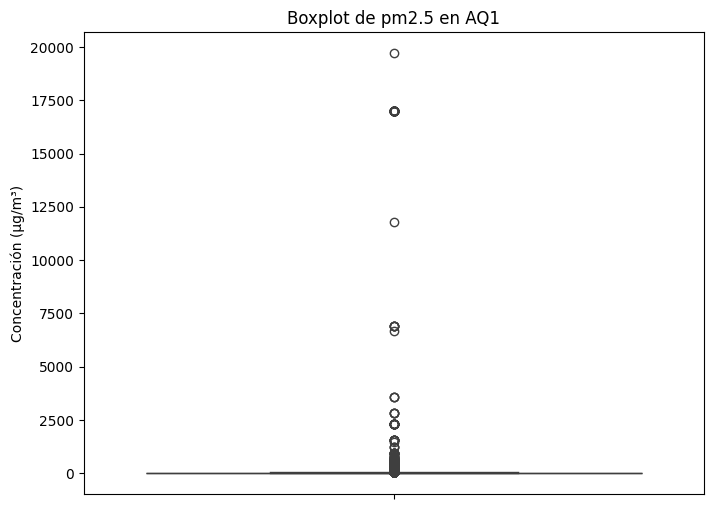

In [ ]:
#Boxplot inicial de pm2.5 en DFP_AQ1
plt.figure(figsize=(8, 6))
sns.boxplot(y=DFP_AQ1['pm2_5'])
plt.title('Boxplot de pm2.5 en AQ1')
plt.ylabel('Concentración (µg/m³)')
plt.show()

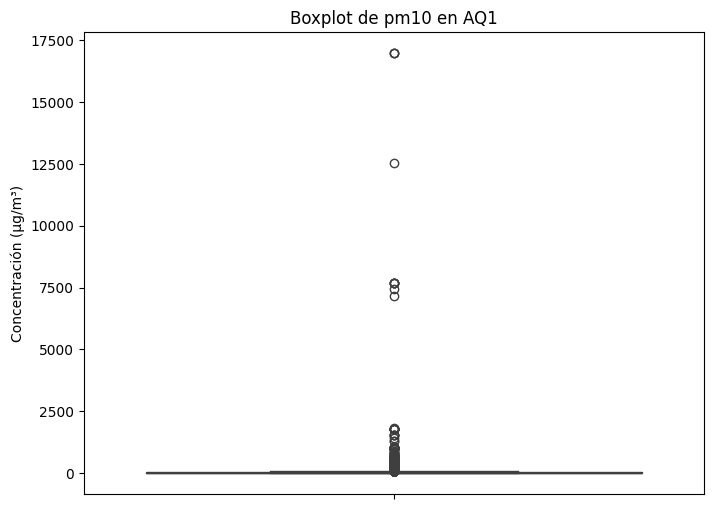

In [ ]:
#Boxplot inicial de pm10 en DFP_AQ1
plt.figure(figsize=(8, 6))
sns.boxplot(y=DFP_AQ1['pm10'])
plt.title('Boxplot de pm10 en AQ1')
plt.ylabel('Concentración (µg/m³)')
plt.show()

# 1.1 **AJUSTE OUTLIERS CUARTILES - DF_AQ_1**

DFP_AQ1 - Número de registros antes: 181862
DFP_AQ1 - Número de registros después de remover outliers: 177887


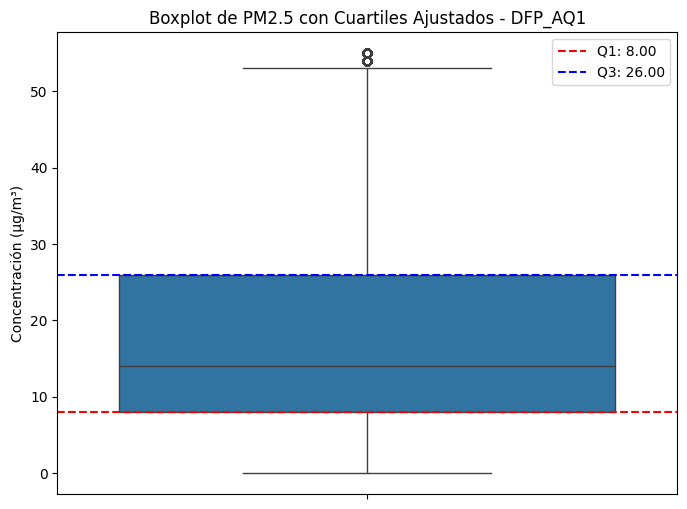

In [114]:
# Primero, eliminamos los outliers usando el método de cuartiles
Q1 = DFP_AQ1['pm2_5'].quantile(0.25)
Q3 = DFP_AQ1['pm2_5'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar el DataFrame para remover los outliers
DFP_AQ1_CPM2_5 = DFP_AQ1[(DFP_AQ1['pm2_5'] >= lower_bound) & (DFP_AQ1['pm2_5'] <= upper_bound)]

# Calcular los cuartiles en el DataFrame filtrado
Q1_filtered = DFP_AQ1_CPM2_5['pm2_5'].quantile(0.25)
Q3_filtered = DFP_AQ1_CPM2_5['pm2_5'].quantile(0.75)

print("DFP_AQ1 - Número de registros antes:", DFP_AQ1.shape[0])
print("DFP_AQ1 - Número de registros después de remover outliers:", DFP_AQ1_CPM2_5.shape[0])

# Graficar el boxplot para el DataFrame filtrado
plt.figure(figsize=(8, 6))
sns.boxplot(y=DFP_AQ1_CPM2_5['pm2_5'])
plt.axhline(Q1_filtered, color='red', linestyle='--', label=f'Q1: {Q1_filtered:.2f}')
plt.axhline(Q3_filtered, color='blue', linestyle='--', label=f'Q3: {Q3_filtered:.2f}')
plt.title('Boxplot de PM2.5 con Cuartiles Ajustados - DFP_AQ1')
plt.ylabel('Concentración (µg/m³)')
plt.legend()
plt.show()


DFP_AQ1 -Número de registros antes: 181862
DFP_AQ1 - Número de registros después de remover outliers: 177819


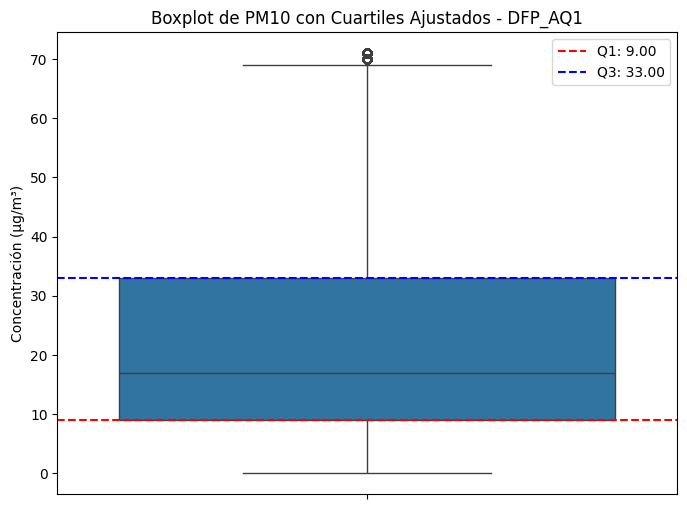

In [113]:
# Primero, eliminamos los outliers usando el método de cuartiles
Q1 = DFP_AQ1['pm10'].quantile(0.25)
Q3 = DFP_AQ1['pm10'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar el DataFrame para remover los outliers
DFP_AQ1_CPM10 = DFP_AQ1[(DFP_AQ1['pm10'] >= lower_bound) & (DFP_AQ1['pm10'] <= upper_bound)]

# Calcular los cuartiles en el DataFrame filtrado
Q1_filtered = DFP_AQ1_CPM10['pm10'].quantile(0.25)
Q3_filtered = DFP_AQ1_CPM10['pm10'].quantile(0.75)

print("DFP_AQ1 -Número de registros antes:", DFP_AQ1.shape[0])
print("DFP_AQ1 - Número de registros después de remover outliers:", DFP_AQ1_CPM10.shape[0])

# Graficar el boxplot para el DataFrame filtrado
plt.figure(figsize=(8, 6))
sns.boxplot(y=DFP_AQ1_CPM10['pm10'])
plt.axhline(Q1_filtered, color='red', linestyle='--', label=f'Q1: {Q1_filtered:.2f}')
plt.axhline(Q3_filtered, color='blue', linestyle='--', label=f'Q3: {Q3_filtered:.2f}')
plt.title('Boxplot de PM10 con Cuartiles Ajustados - DFP_AQ1')
plt.ylabel('Concentración (µg/m³)')
plt.legend()
plt.show()


# 2. **Boxplot for DF_AQ_2**

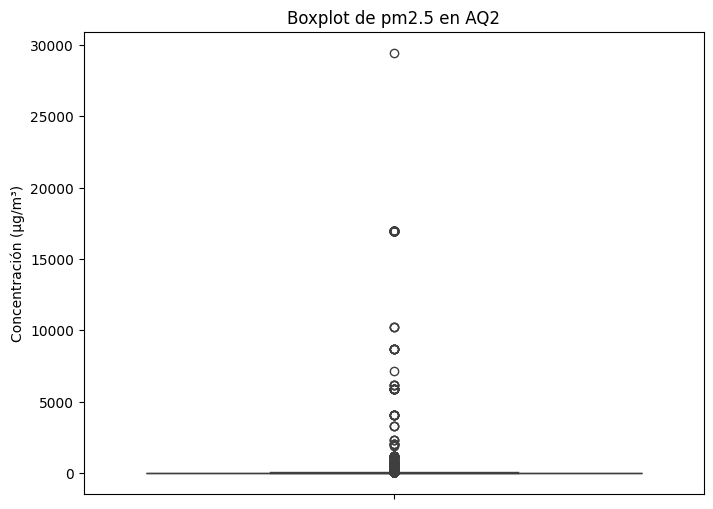

In [98]:
#Boxplot inicial de pm2.5 en DFP_AQ2
plt.figure(figsize=(8, 6))
sns.boxplot(y=DFP_AQ2['pm2_5'])
plt.title('Boxplot de pm2.5 en AQ2')
plt.ylabel('Concentración (µg/m³)')
plt.show()

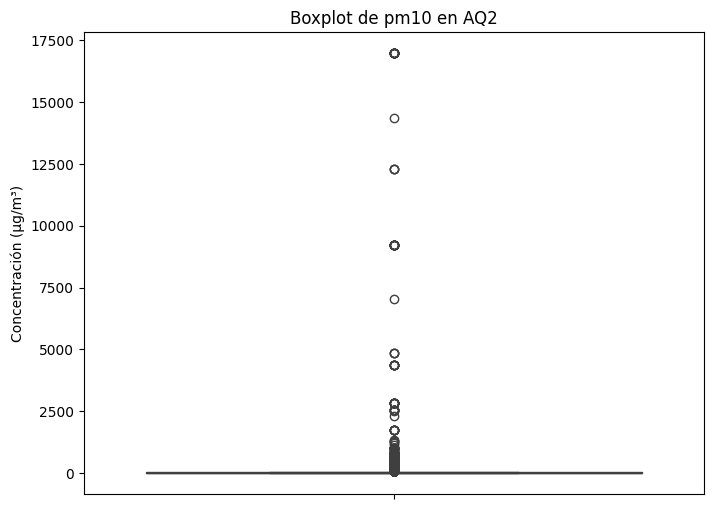

In [99]:
#Boxplot inicial de pm10 en DFP_AQ2
plt.figure(figsize=(8, 6))
sns.boxplot(y=DFP_AQ2['pm10'])
plt.title('Boxplot de pm10 en AQ2')
plt.ylabel('Concentración (µg/m³)')
plt.show()

# 2.1 **AJUSTE OUTLIERS CUARTILES - DF_AQ_2**

DFP_AQ2 - Número de registros antes: 148502
DFP_AQ2 -Número de registros después de remover outliers: 143968


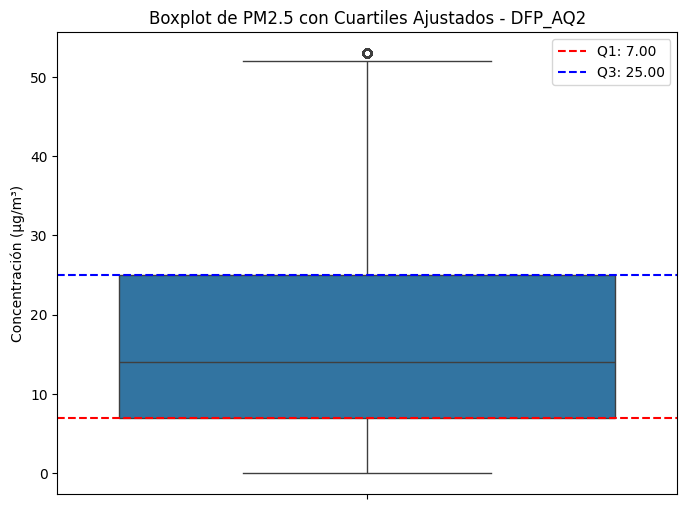

In [112]:
# Primero, eliminamos los outliers usando el método de cuartiles
Q1 = DFP_AQ2['pm2_5'].quantile(0.25)
Q3 = DFP_AQ2['pm2_5'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar el DataFrame para remover los outliers
DFP_AQ2_CPM2_5 = DFP_AQ2[(DFP_AQ2['pm2_5'] >= lower_bound) & (DFP_AQ2['pm2_5'] <= upper_bound)]

# Calcular los cuartiles en el DataFrame filtrado
Q1_filtered = DFP_AQ2_CPM2_5['pm2_5'].quantile(0.25)
Q3_filtered = DFP_AQ2_CPM2_5['pm2_5'].quantile(0.75)

print("DFP_AQ2 - Número de registros antes:", DFP_AQ2.shape[0])
print("DFP_AQ2 -Número de registros después de remover outliers:", DFP_AQ2_CPM2_5.shape[0])

# Graficar el boxplot para el DataFrame filtrado
plt.figure(figsize=(8, 6))
sns.boxplot(y=DFP_AQ2_CPM2_5['pm2_5'])
plt.axhline(Q1_filtered, color='red', linestyle='--', label=f'Q1: {Q1_filtered:.2f}')
plt.axhline(Q3_filtered, color='blue', linestyle='--', label=f'Q3: {Q3_filtered:.2f}')
plt.title('Boxplot de PM2.5 con Cuartiles Ajustados - DFP_AQ2')
plt.ylabel('Concentración (µg/m³)')
plt.legend()
plt.show()


DFP_AQ2 -Número de registros antes: 148502
DFP_AQ2 - Número de registros después de remover outliers: 143108


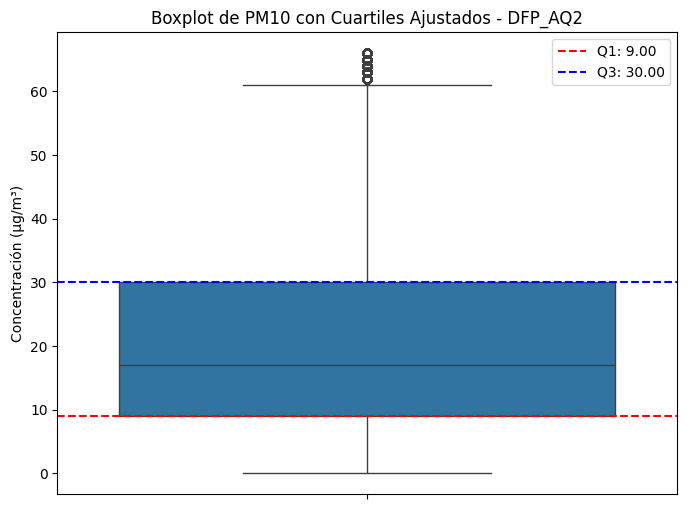

In [115]:
# Primero, eliminamos los outliers usando el método de cuartiles
Q1 = DFP_AQ2['pm10'].quantile(0.25)
Q3 = DFP_AQ2['pm10'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar el DataFrame para remover los outliers
DFP_AQ2_CPM10 = DFP_AQ2[(DFP_AQ2['pm10'] >= lower_bound) & (DFP_AQ2['pm10'] <= upper_bound)]

# Calcular los cuartiles en el DataFrame filtrado
Q1_filtered = DFP_AQ2_CPM10['pm10'].quantile(0.25)
Q3_filtered = DFP_AQ2_CPM10['pm10'].quantile(0.75)

print("DFP_AQ2 -Número de registros antes:", DFP_AQ2.shape[0])
print("DFP_AQ2 - Número de registros después de remover outliers:", DFP_AQ2_CPM10.shape[0])

# Graficar el boxplot para el DataFrame filtrado
plt.figure(figsize=(8, 6))
sns.boxplot(y=DFP_AQ2_CPM10['pm10'])
plt.axhline(Q1_filtered, color='red', linestyle='--', label=f'Q1: {Q1_filtered:.2f}')
plt.axhline(Q3_filtered, color='blue', linestyle='--', label=f'Q3: {Q3_filtered:.2f}')
plt.title('Boxplot de PM10 con Cuartiles Ajustados - DFP_AQ2')
plt.ylabel('Concentración (µg/m³)')
plt.legend()
plt.show()
